In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ttest_ind
from IPython.display import display, Markdown

In [2]:
# Load enriched data
with open("/Users/hugomoreno/thesis-hallucination/data/intermediate/outputs_enriched.json", "r") as f:
    data = json.load(f)

# Build DataFrame with all categories
df = pd.DataFrame(data)

# Display basic info
print("Loaded enriched data with categories:", df['category'].unique())

Loaded enriched data with categories: ['A' 'B' 'C' 'D' 'E' 'F']


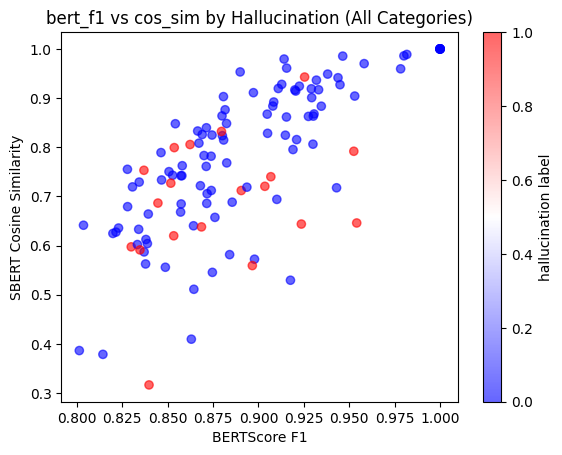

In [5]:
# Ensure the output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)

# Your scatter plot code
plt.figure()
plt.scatter(df['bert_f1'], df['cos_sim'], c=df['hallucination'], cmap='bwr', alpha=0.6)
plt.xlabel('BERTScore F1')
plt.ylabel('SBERT Cosine Similarity')
plt.title('bert_f1 vs cos_sim by Hallucination (All Categories)')
plt.colorbar(label='hallucination label')

# Save to file (before plt.show())
plt.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/bertf1_vs_cosim_scatter.png", dpi=300, bbox_inches="tight")

# Then display interactively if you like
plt.show()

In [14]:
# Define prompt-level features to summarize
prompt_features = [
    'token_len', 'char_len', 'entity_count',
    'pronoun_ratio', 'imperative_flag',
    'readability_score', 'punct_density'
]

# Compute summary stats for all prompt-level features
stats = df[prompt_features].agg(['mean', 'std', 'count']).round(3).T

# Reset index for display and rename columns
stats = stats.reset_index().rename(columns={
    'index': 'Feature',
    'mean': 'Mean',
    'std': 'SD',
    'count': 'N'
})

# Ensure output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)

# Display as formatted markdown table
md = stats.to_markdown(index=False)
display(Markdown("**Summary Statistics for Prompt-Level Features**"))
display(Markdown(md))

# Save as CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/prompt_features_summary.csv"
stats.to_csv(csv_path, index=False)

print(f"Saved prompt-level summary table to {csv_path}")

**Summary Statistics for Prompt-Level Features**

| Feature           |   Mean |     SD |   N |
|:------------------|-------:|-------:|----:|
| token_len         | 12.225 |  4.626 | 120 |
| char_len          | 57.475 | 19.805 | 120 |
| entity_count      |  1.333 |  0.853 | 120 |
| pronoun_ratio     |  0.057 |  0.069 | 120 |
| imperative_flag   |  0.4   |  0.492 | 120 |
| readability_score | 59.442 | 24.539 | 120 |
| punct_density     |  0.024 |  0.012 | 120 |

Saved prompt-level summary table to /Users/hugomoreno/thesis-hallucination/result/tables/prompt_features_summary.csv


In [13]:
# Calculate summary statistics for core metrics
stats = df.groupby('hallucination')[['bert_f1', 'cos_sim']].agg(['mean', 'std', 'count']).round(3)

# Reformat MultiIndex columns
stats.columns = ['_'.join(col) for col in stats.columns]
stats = stats.reset_index().rename(columns={'hallucination': 'Hallucination'})

# Ensure output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)

# Save CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/summary_stats_core_metrics.csv"
stats.to_csv(csv_path, index=False)

# Display as a formatted markdown table
md_table = stats.to_markdown(index=False)
display(Markdown("**Summary Statistics for Core Metrics by Hallucination Label**"))
display(Markdown(md_table))

print(f"Saved core metrics summary to:\n- CSV: {csv_path}")

**Summary Statistics for Core Metrics by Hallucination Label**

|   Hallucination |   bert_f1_mean |   bert_f1_std |   bert_f1_count |   cos_sim_mean |   cos_sim_std |   cos_sim_count |
|----------------:|---------------:|--------------:|----------------:|---------------:|--------------:|----------------:|
|               0 |          0.893 |          0.05 |             101 |          0.789 |         0.15  |             101 |
|               1 |          0.879 |          0.04 |              19 |          0.691 |         0.132 |              19 |

Saved core metrics summary to:
- CSV: /Users/hugomoreno/thesis-hallucination/result/tables/summary_stats_core_metrics.csv


In [15]:
# Features to test
features_to_test = ['bert_f1', 'cos_sim']

# Calculate t-test results
results = []
for feat in features_to_test:
    grp0 = df[df['hallucination'] == 0][feat]
    grp1 = df[df['hallucination'] == 1][feat]
    if len(grp0) > 1 and len(grp1) > 1:
        t_stat, p_val = ttest_ind(grp0, grp1, equal_var=False)
        results.append({'Feature': feat, 't_stat': round(t_stat, 2), 'p_value': round(p_val, 3)})
    else:
        results.append({'Feature': feat, 't_stat': None, 'p_value': None})

# Build DataFrame
tt_df = pd.DataFrame(results)

# Display as markdown table
display(Markdown("**T-Test Results for Core Metrics by Hallucination Label**"))
display(Markdown(tt_df.to_markdown(index=False)))

# Ensure output directory exists
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)

# Save as CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/core_metrics_t_tests.csv"
tt_df.to_csv(csv_path, index=False)

print(f"Saved t-test results to {csv_path}")

**T-Test Results for Core Metrics by Hallucination Label**

| Feature   |   t_stat |   p_value |
|:----------|---------:|----------:|
| bert_f1   |     1.36 |     0.184 |
| cos_sim   |     2.89 |     0.007 |

Saved t-test results to /Users/hugomoreno/thesis-hallucination/result/tables/core_metrics_t_tests.csv


In [17]:
# Compute crosstab for question_type vs. hallucination
qt_ct = pd.crosstab(df['question_type'], df['hallucination'])

# Ensure output directories exist
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/tables", exist_ok=True)
os.makedirs("/Users/hugomoreno/thesis-hallucination/result/figures", exist_ok=True)

# Save the table as CSV
csv_path = "/Users/hugomoreno/thesis-hallucination/result/tables/question_type_distribution.csv"
qt_ct.to_csv(csv_path)

# Plot and save bar chart
fig, ax = plt.subplots(figsize=(6, 4))
qt_ct.plot(kind='bar', ax=ax)
ax.set_xlabel('Question Type')
ax.set_ylabel('Count')
ax.set_title('Question Type Distribution by Hallucination Label')
ax.legend(title='Hallucination')
plt.tight_layout()
fig.savefig("/Users/hugomoreno/thesis-hallucination/result/figures/question_type_distribution.png", dpi=300, bbox_inches="tight")
plt.close(fig)

# (Optional) Display inline if running in a notebook
print(qt_ct)

hallucination   0  1
question_type       
what           27  3
who            12  0


In [18]:
# Baseline threshold evaluations
print("\nBaseline evaluations:")
for t in [0.85, 0.90]:
    preds = (df['bert_f1'] < t).astype(int)
    acc = accuracy_score(df['hallucination'], preds)
    f1 = f1_score(df['hallucination'], preds)
    print(f"BERT F1 < {t}: Acc = {acc:.2f}, F1 = {f1:.2f}")

# Combined threshold rule
preds_comb = ((df['bert_f1'] < 0.90) | (df['cos_sim'] < 0.75)).astype(int)
acc_c = accuracy_score(df['hallucination'], preds_comb)
f1_c = f1_score(df['hallucination'], preds_comb)
print(f"\nCombined rule (F1<0.90 or cos<0.75): Acc = {acc_c:.2f}, F1 = {f1_c:.2f}")


Baseline evaluations:
BERT F1 < 0.85: Acc = 0.72, F1 = 0.23
BERT F1 < 0.9: Acc = 0.47, F1 = 0.29

Combined rule (F1<0.90 or cos<0.75): Acc = 0.47, F1 = 0.35
